<a href="https://colab.research.google.com/github/nahumsa/pennylane-notebooks/blob/main/VQC_Pennylane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instlling pennylane in colab
from IPython.display import clear_output
! pip install pennylane
clear_output()

# Variational Quantum Classifier

# 1) Introduction
There are several applications for quantum computers, one of the most promising applications is Quantum Machine Learning. 

Quantum Machine Learning is a novel field which aims to use Quantum Computer to do machine learning tasks, just as the name states. One of such tasks is the classification problem, where we aim to split the data into different classes. One example of a classification problem is when it is needed to classify if an email is a spam or not, the data would be the email content and we would train examples of spam mails and not spam mails in order to create a model of what a spam mail is and then use this model for novel data to solve our task.

For our example I will talk about the Variational Quantum Classifier which is an Hybrid Quantum-Classical algorithm that is used to classify data. In this demo I will be using [Pennylane](https://pennylane.ai/).

# 2) Algorithm

The Variational Quantum Classifier (VQC) is consists of three parts: 

1. Encoding or Embedding;
2. Parametrized Quantum Circuit (Ansatz);
3. Loss Function.

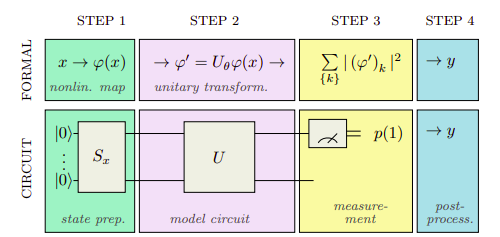

Image from [Schuld et al.](https://arxiv.org/pdf/1804.00633.pdf)

## 2.1) Quantum Embedding

Since we are using quantum circuits, we need a way to transform classical data into quantum data, this process is called Quantum Embedding and can be represented as:

$$
\vec{x} \mapsto | \psi (\vec{x}) \rangle
$$

Here I will present two kinds of quantum embeddings:

- Basis Embedding
- Amplitude Embedding
- Angle Embeddding

### 2.1.1) Basis Embedding

In this kind of embedding, we encode bit strings into quantum states by mapping them to the computational basis. Thus if we have a dataset $\mathcal{D} = \{ x^{(1)}, \dots, x^{(M)} \}$ with cardinality $M$ we can encode all the dataset into a superposition of computational basis states:

$$
| \mathcal{D} \rangle = \frac{1}{\sqrt{M}} \sum_{m=1}^M | x^{(m)} \rangle
$$

As an example we have $\mathcal{D} = \{ 00 ,11 \}$, we can encode this dataset as: 

$$
| \mathcal{D} \rangle = \frac{1}{2} \big[ |00 \rangle + | 11 \rangle \big]
$$

This embedding can be done using the pennylane template [`BasisEmbedding`](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.templates.embeddings.BasisEmbedding.html). Let's show one example:

In [ ]:
import pennylane as qml
import numpy as np

# Initialize the device
n_qubits = 2
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev)
def basis_embedding(data):
    
    # Embedding
    qml.templates.BasisEmbedding(data, wires=range(n_qubits))

    return qml.state()

features=np.array([0, 1])

print(f"Quantum State |01>: {basis_embedding(features)}")

features=np.array([1,0])

print(f"Quantum State |10>: {basis_embedding(features)}")

Quantum State |01>: [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
Quantum State |10>: [0.+0.j 0.+0.j 1.+0.j 0.+0.j]


As we can see in the code, the data is properly encoded into the computational basis. However, this is not a very efficient encoding, mainly because we want to encode continous data and this kind of encoding would be very inneficient to do this.

### 2.1.2) Amplitude Embedding

In this encoding we will encode the data into amplitudes of a quantum state. Since all quantum states must be normalized, the first step is to normalize our entry data. Thus a normalized N dimensional datapoint x is represented by the amplitudes of the n-qubit quantum state $| \psi_x \rangle$:

$$
| \psi_x \rangle = \sum_{i=1}^N x_i | i \rangle
$$

Where $x_i$ is the i-th element of x and $| i \rangle$ is the i-th computational basis state.

For instance let's encode the datapoint $x = (0, 1, 4, 0)$ into a quantum state. First the normalized datapoint is $x_{\mathrm{norm}} = \frac{1}{\sqrt{4.123}} ( 0, 1, -4, 0)$, then we can encode into a quantum state:

$$
| \psi_x \rangle = \frac{1}{\sqrt{4.123}} \bigg[ | 01 \rangle - | 10 \rangle \bigg]
$$

This can be done in pennylane using [`AmplitudeEmbedding`](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.templates.embeddings.AmplitudeEmbedding.html), which encodes a vector of lenght $2^n$  into n qubits.

In [ ]:
# Initialize the device
n_qubits = 2
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev)
def basis_embedding(data):
    
    # Embedding
    # This will normalize the data for us
    qml.templates.AmplitudeEmbedding(data, wires=range(n_qubits), normalize=True)

    return qml.state()

x = np.array([0., 1., 4., 0.])
x_norm = x/np.linalg.norm(x)
print(f"Normalized datapoint: {x_norm}")
print(f"Quantum State: {basis_embedding(x)}")

Normalized datapoint: [0.         0.24253563 0.9701425  0.        ]
Quantum State: [0.        +0.j 0.24253563+0.j 0.9701425 +0.j 0.        +0.j]


### 2.1.3) Angle Embedding

Another approach is to encode data into qubit rotations, this has the downside of needing n qubits for n-dimensional datapoint, but has the upside of being more easy to implement.

A N-dimensional datapoint $x$ will be represented by N qubits of the form:

$$
    | \psi_x \rangle =  \bigotimes_{i=1}^{N} R_j(x_i) | 0 \rangle
$$

Where $R_j$ is the rotation on the j-th axis and i can be around the X,Y and Z axis, the $\bigotimes$ symbol representes that each rotation is independent from each other and act only on one qubit.

This can be done in pennylane using [`AngleEmbedding`](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.templates.embeddings.AngleEmbedding.html).

In [ ]:
# Initialize the device
n_qubits = 2
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev)
def basis_embedding(data):
    
    # Embedding
    # This will normalize the data for us
    qml.templates.AngleEmbedding(data, wires=range(n_qubits))

    return qml.state()

x = np.array([.5, 1.2])

print(f"Quantum State: {basis_embedding(x)}\n")
print(basis_embedding.draw())

Quantum State: [ 0.79967793+0.j          0.        -0.54708911j  0.        -0.2041913j
 -0.13969478+0.j        ]

 0: ──RX(0.5)──╭┤ State 
 1: ──RX(1.2)──╰┤ State 



## 2.2) Variational Circuit

After encoding the data we need to create our proper Quantum Neural Network which will consist of a parametrized quantum circuit. The construction of this circuit can be done in plethora of ways which can be seen in the pennylane [layers templates page](https://pennylane.readthedocs.io/en/stable/introduction/templates.html) for instance. 

The main idea is to construct a parametrized unitary $U(\theta)$ which we will tune the parameters in order to tell us from which class the data belongs.

## 2.3) Loss Function

The loss function is the function that we want to minimize in order to solve the task that we want. There are several loss functions that can be used and will further explained in future posts. 

# 3) Using VQC for the iris dataset

Now I will implement the Variational Quantum Classifier for the famous [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris). The goal for this dataset is to classify the class of iris plant using attributes of the plant.

In [ ]:
import sys
import pennylane as qml
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## 3.1) Loading the dataset

We load the Iris dataset from sklearn datasets and split into a training and validation split as usual..

In [ ]:
iris = datasets.load_iris()
X = iris.data[:, :]
Y = iris.target

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=42)

## 3.2) Constructing the Variational Circuit

In order to construct the variational circuit, we need three steps:
- Embed the data into a quantum state: Which II use the angle embedding;
- Create a Parametetrized Quantum Circuit (PQC): Which I will use the Strongly Entangling Layers Template;
- Measure the qubits: Since we are classifying three classes, I will measure all three qubits using the expectation Z value on each one.

In [ ]:
n_qubits = X_train.shape[1]
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev)
def circuit(weights, data):
    # Embedding
    qml.templates.AngleEmbedding(data, wires=range(n_qubits))
    
    # Create Parametrized layer
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    return [qml.expval(qml.PauliZ(0)) ,qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2))]

## 3.2) Defining the cost function

In order to use the mean squared error loss function it is need to one hot encode each label into a vector and then use each expectation value from the circuit to approximate each class.

In [ ]:
def cost(weights, x, y):
    """ Define the cost function for the classification task.
    """
    epoch_loss = []
    label2vec = {
        0: [1, 0, 0],
        1: [0, 1, 0],
        2: [0, 0, 1]
    }
    
    for x_data, y_data in zip(x,y):
        c = circuit(weights, x_data)
        label = label2vec[y_data]
        c, label = np.array(c),np.array(label)
        s = np.sum(abs(c - label)**2)
    
        epoch_loss.append(s)
    
    return np.sum(epoch_loss) / len(epoch_loss)

# Define the accuracy
accuracy = lambda x,y: np.sum(x == y) / len(x)

def iterate_minibatches(inputs, targets, batch_size):
    """ A generator for batches of the input data
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

## 3.5) Training

In order to train we need to define hyperparameters, weight initialization and the optimizer.

- Optimizer: I choose to use Adam;

- Intialization: I choose to initialize with a random uniform distribution of angles, even though this has been show to present barren plateaus on the loss landscape, maybe in a future post I will talk about mitigating barren plateaus;

- Hyperparameters: I choose 2 layers for the PQC, and a learning rate of 0.1;

In [ ]:
# Hyperparameters
layers = 2
learning_rate = 0.05
epochs = 10
batch_size = 10

# Optimizer
opt = qml.AdamOptimizer(learning_rate)#, beta1=0.9, beta2=0.999)

# Initialize Random Weights
params = np.random.uniform(low= 0, high= np.pi, size=(layers, n_qubits, 3))

# Helpers
val_acc = []
t_acc = []
t_loss = []

In [ ]:
# Training
for i in tqdm(range(epochs)):
    train_acc = []
    for Xbatch, Ybatch in iterate_minibatches(X_train, Y_train, batch_size=batch_size):
        params = opt.step(lambda v: cost(v, Xbatch, Ybatch), params)
    
    
    train_predictions = []
    for x in X_train:
        pred = circuit(params, x)
        label = np.argmax(pred)
        train_predictions.append(label)
    
    train_acc = accuracy(train_predictions,Y_train)
    t_acc.append(train_acc)   
    
    valid_predictions = []
    for x in X_valid:
        pred = circuit(params, x)
        label = np.argmax(pred)
        valid_predictions.append(label)
    
    valid_acc = accuracy(valid_predictions,Y_valid)
    val_acc.append(valid_acc)

    loss = np.mean(cost(params, X_train, Y_train))
    t_loss.append(loss)

100%|██████████| 10/10 [00:41<00:00,  4.16s/it]


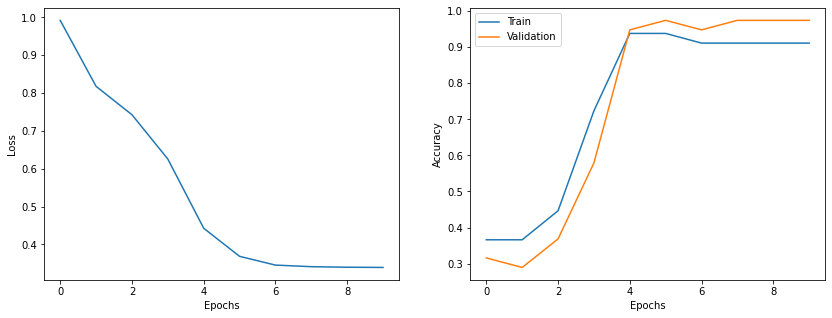

In [ ]:
import matplotlib.pyplot as plt

epochs = range(len(t_loss))


fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs, t_loss)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(epochs, t_acc, label='Train')
ax2.plot(epochs, val_acc, label='Validation')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
plt.legend()
plt.show()

# References

- [Variational Classifier Pennylane Demo](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html)

- [Quantum Embedding](https://pennylane.ai/qml/glossary/quantum_embedding.html)

- [Circuit-Centric quantum classifiers](https://arxiv.org/abs/1804.00633)